In [30]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from scipy.ndimage import sobel
from tensorflow.keras.models import load_model

In [31]:
data_dir = 'Banana Leaf Disease Detection dataset'

In [32]:
datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    rotation_range=40,  # Random rotations
    width_shift_range=0.2,  # Horizontal shifts
    height_shift_range=0.2,  # Vertical shifts
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Horizontal flip
    fill_mode='nearest'  # Fill in missing pixels
)

In [33]:
train_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='validation')

class_dict = train_generator.class_indices
for class_name, class_index in class_dict.items():
    print(f"Class: {class_name}, Index: {class_index}")

Found 2615 images belonging to 7 classes.
Found 650 images belonging to 7 classes.
Class: Banana Black Sigatoka Disease, Index: 0
Class: Banana Bract Mosaic Virus Disease, Index: 1
Class: Banana Healthy Leaf, Index: 2
Class: Banana Insect Pest Disease, Index: 3
Class: Banana Moko Disease, Index: 4
Class: Banana Panama Disease, Index: 5
Class: Banana Yellow Sigatoka Disease, Index: 6


In [34]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights)

{0: 0.8707958707958708, 1: 1.1674107142857142, 2: 0.6779880736323568, 3: 0.6779880736323568, 4: 1.0582760016187778, 5: 1.4204236827810972, 6: 2.5241312741312742}


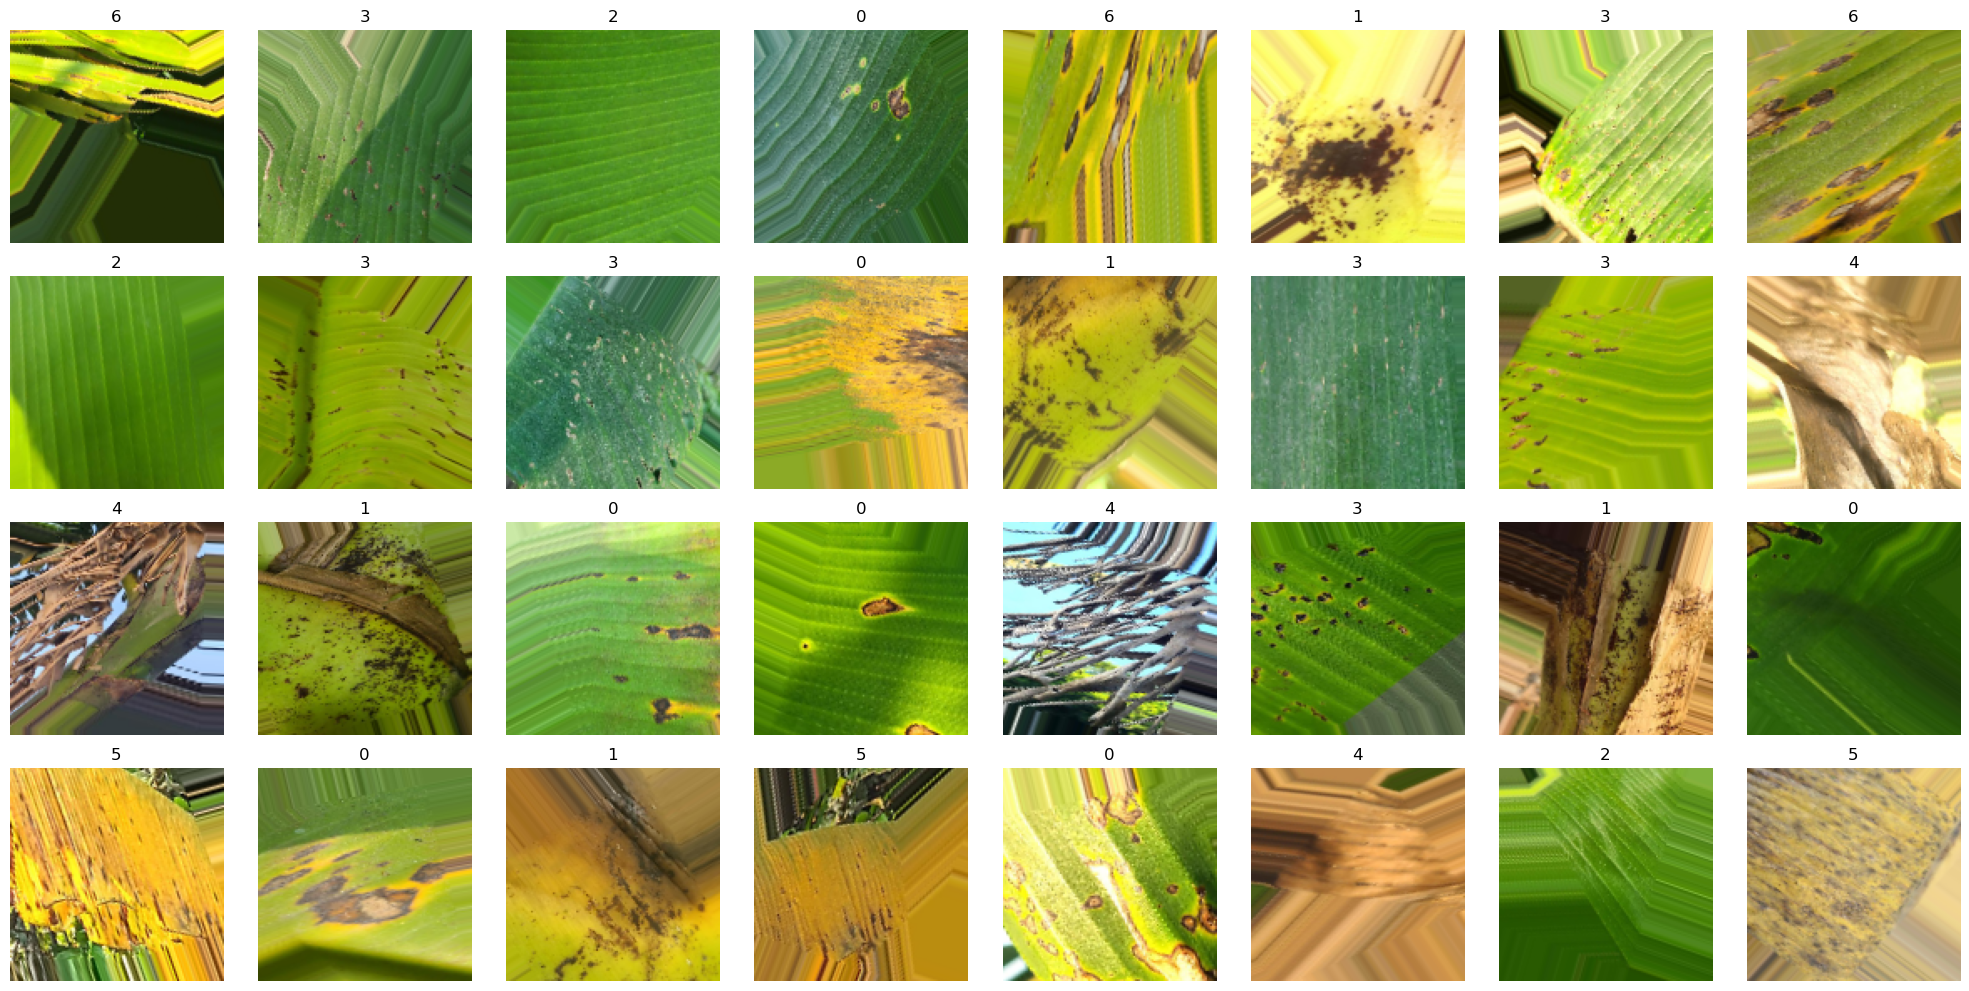

In [35]:
images, labels = next(train_generator)

def plot_images(images_arr, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(np.argmax(lbl))
    plt.tight_layout()
    plt.show()

plot_images(images, labels)

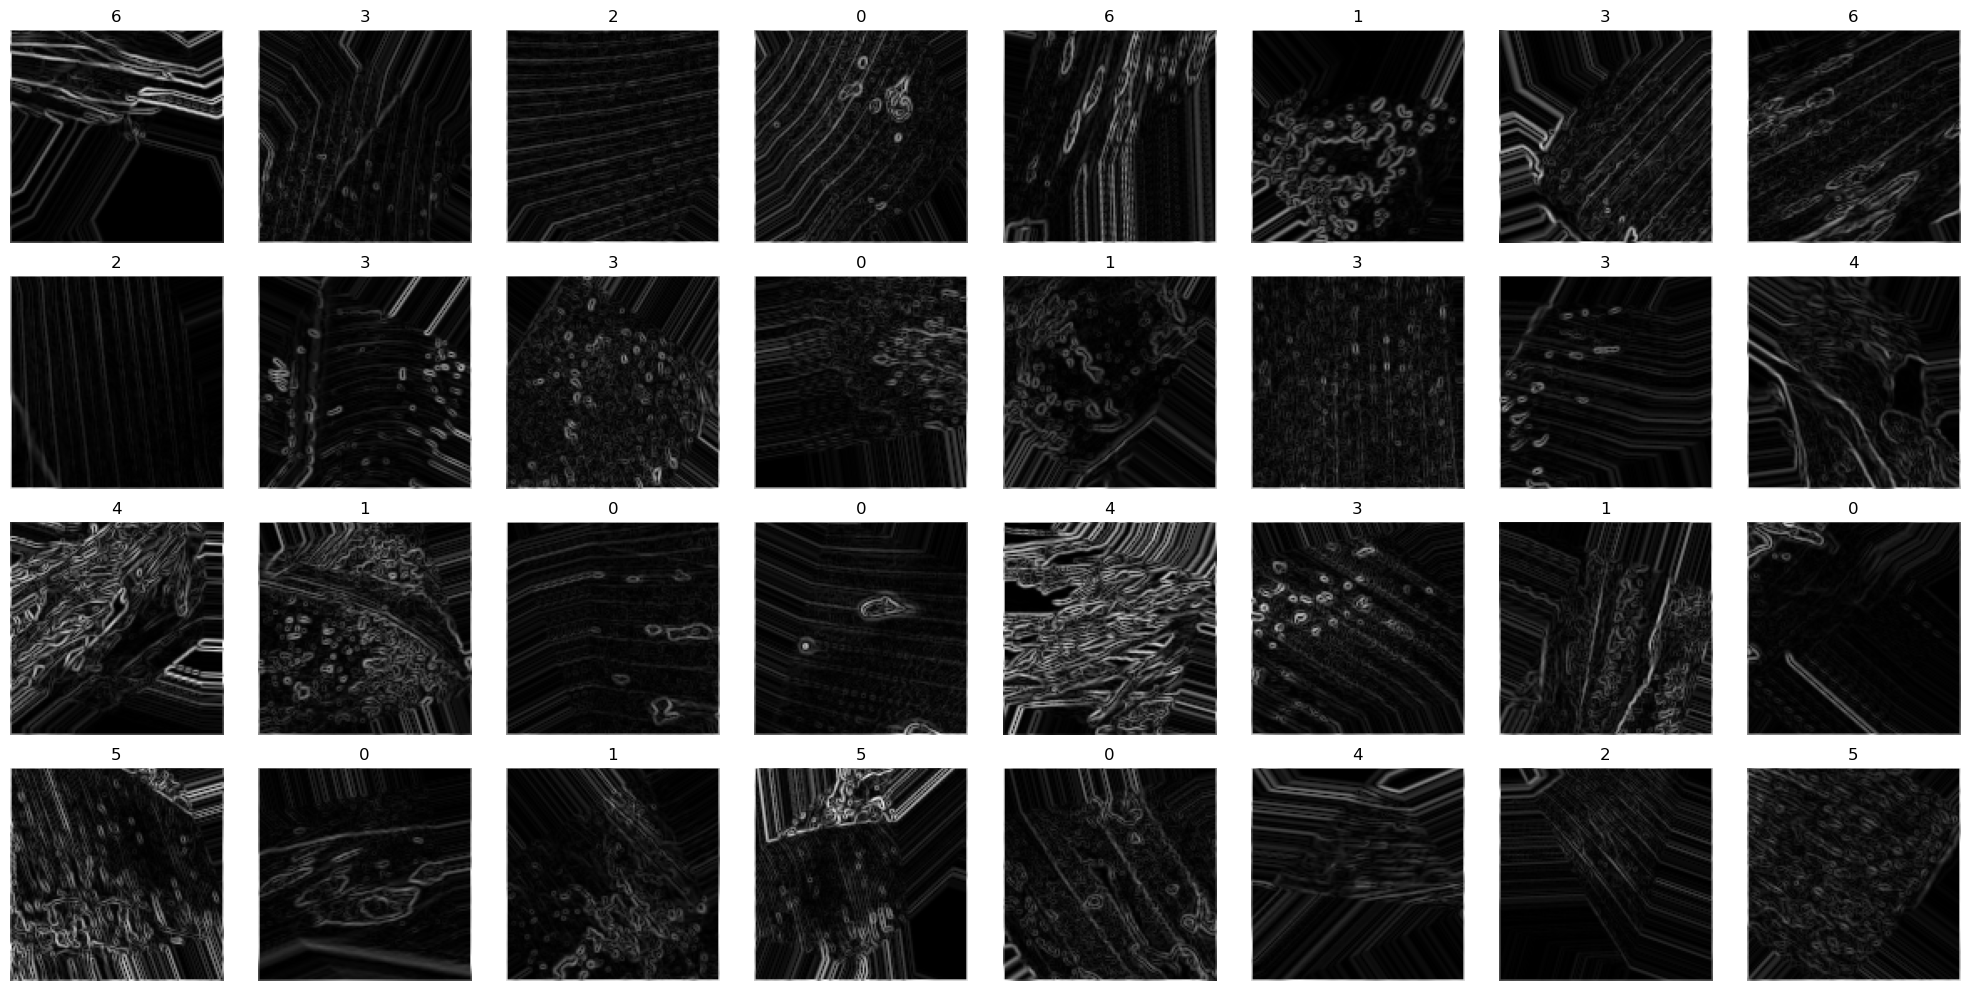

In [36]:
def apply_sobel(images_arr):
    sobel_images = []
    for img in images_arr:
        gray_img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale
        sobel_x = sobel(gray_img, axis=0, mode='constant')
        sobel_y = sobel(gray_img, axis=1, mode='constant')
        sobel_img = np.hypot(sobel_x, sobel_y)
        sobel_images.append(sobel_img)
    return np.array(sobel_images)

sobel_images = apply_sobel(images)

def plot_sobel_images(original_images, sobel_images, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for orig_img, sob_img, lbl, ax in zip(original_images, sobel_images, labels_arr, axes):
        ax.imshow(sob_img, cmap='gray')
        ax.axis('off')
        ax.set_title(np.argmax(lbl))
    plt.tight_layout()
    plt.show()

plot_sobel_images(images, sobel_images, labels)


In [37]:
print(type(train_generator))

<class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>


In [38]:
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=False,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=False,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    return Multiply()([input_feature, cbam_feature])

In [39]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, padding='same', strides=stride,
               kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    
    x = Conv2D(filters, kernel_size, padding='same', strides=1,
               kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, strides=stride,
                          kernel_regularizer=l2(1e-4))(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('swish')(x)
    return x

In [42]:
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation, Add,
    MaxPooling2D, Dropout, Flatten, Dense, Input, Reshape,
    GlobalAveragePooling2D, GlobalMaxPooling2D
)
def create_advanced_model(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)
    
    # Initial Stem
    x = Conv2D(64, 7, strides=2, padding='same', 
               kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Residual Blocks with Attention
    x = residual_block(x, 128)
    x = channel_attention(x)
    x = MaxPooling2D(2)(x)
    x = Dropout(0.3)(x)
    
    x = residual_block(x, 256)
    x = channel_attention(x)
    x = MaxPooling2D(2)(x)
    x = Dropout(0.4)(x)
    
    x = residual_block(x, 512)
    x = channel_attention(x)
    x = GlobalAveragePooling2D()(x)
    
    # Dense Head
    x = Dense(512, activation='swish', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation='swish', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(7, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

In [43]:
model = create_advanced_model()
model.compile(optimizer=Adam(learning_rate=1e-4, weight_decay=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 64, 64, 64)        │           9,472 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_8         │ (None, 64, 64, 64)        │             256 │ conv2d_8[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_6 (Activation)     │ (None, 64, 64, 64)        │               0 │ batch_normalization_8[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 64)        │               0 │ activation_6[0][0]         │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_9         │ (None, 32, 32, 128)       │             512 │ conv2d_9[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_7 (Activation)     │ (None, 32, 32, 128)       │               0 │ batch_normalization_9[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 32, 32, 128)       │         147,584 │ activation_7[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 32, 32, 128)       │           8,320 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_10        │ (None, 32, 32, 128)       │             512 │ conv2d_10[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_11        │ (None, 32, 32, 128)       │             512 │ conv2d_11[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 32, 32, 128)       │               0 │ batch_normalization_10[0]… │
│                               │                           │                 │ batch_normalization_11[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_8 (Activation)     │ (None, 32, 32, 128)       │               0 │ add_2[0][0]                │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 5,324,935 (20.31 MB)

 Trainable params: 5,317,895 (20.29 MB)

 Non-trainable params: 7,040 (27.50 KB)

In [45]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('best_advanced_model.keras', save_best_only=True),
    ReduceLROnPlateau(factor=0.5, patience=3)
]

In [55]:
history = model.fit(
    train_generator,
    epochs=20,  # Set this to a higher number
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.5278 - loss: 1.7243 - precision: 0.5700 - recall: 0.4555 - val_accuracy: 0.2108 - val_loss: 2.2863 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.5669 - loss: 1.5943 - precision: 0.6058 - recall: 0.5046 - val_accuracy: 0.2108 - val_loss: 3.0321 - val_precision: 0.2108 - val_recall: 0.2108 - learning_rate: 1.0000e-04
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.6358 - loss: 1.3665 - precision: 0.6725 - recall: 0.5856 - val_accuracy: 0.2108 - val_loss: 3.9213 - val_precision: 0.2108 - val_recall: 0.2108 - learning_rate: 1.0000e-04
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.7178 - loss: 1.1625 - precision: 0.7489 - recall: 0.6906 - val_accuracy: 0.2108 - val_loss: 4.8467 - val_precision: 0.2121 - val_recall: 0.2108 - learning_rate: 1.0000e-04
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 181s 2

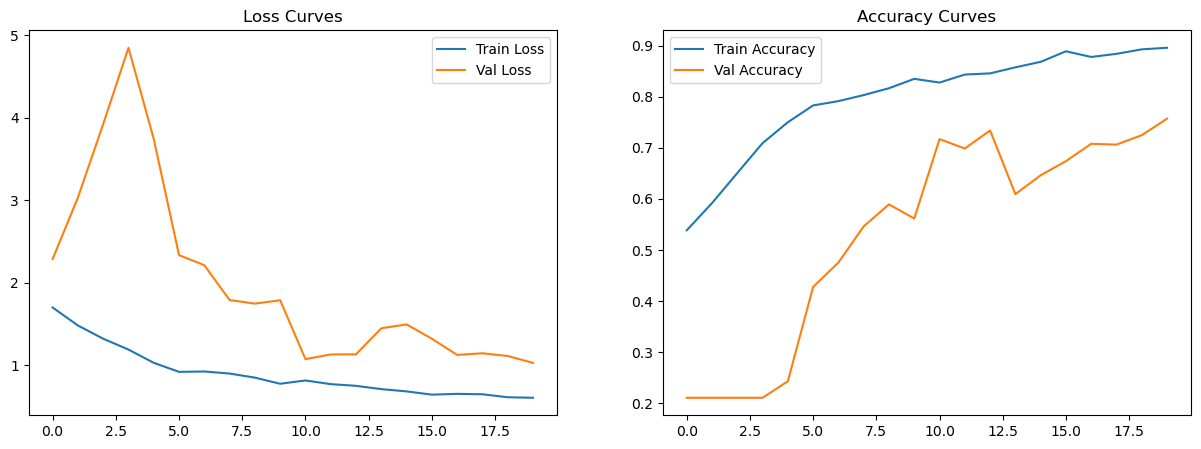

In [56]:
# Plot training metrics
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 411ms/step
              precision    recall  f1-score   support

           0       0.18      0.07      0.10       107
           1       0.10      0.07      0.08        80
           2       0.17      0.18      0.18       137
           3       0.19      0.34      0.25       137
           4       0.09      0.10      0.10        88
           5       0.09      0.08      0.08        65
           6       0.08      0.03      0.04        36

    accuracy                           0.15       650
   macro avg       0.13      0.12      0.12       650
weighted avg       0.14      0.15      0.14       650



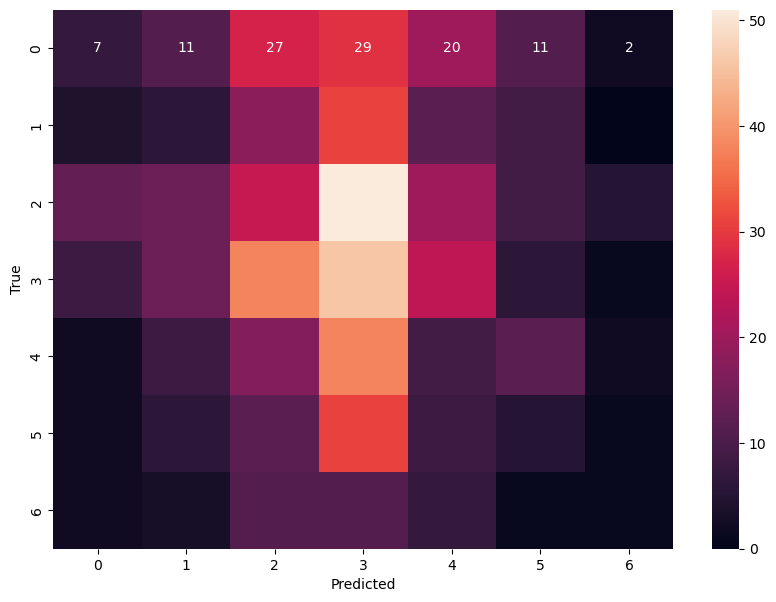

In [57]:
y_pred = np.argmax(model.predict(val_generator), axis=1)
y_true = val_generator.classes

print(classification_report(y_true, y_pred))
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [58]:
model.save('best_advanced_model.keras')


In [59]:
loaded_model = load_model('best_advanced_model.keras') 
loaded_model.summary() 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 64, 64, 64)        │           9,472 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_8         │ (None, 64, 64, 64)        │             256 │ conv2d_8[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_6 (Activation)     │ (None, 64, 64, 64)        │               0 │ batch_normalization_8[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 64)        │               0 │ activation_6[0][0]         │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_9         │ (None, 32, 32, 128)       │             512 │ conv2d_9[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_7 (Activation)     │ (None, 32, 32, 128)       │               0 │ batch_normalization_9[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 32, 32, 128)       │         147,584 │ activation_7[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 32, 32, 128)       │           8,320 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_10        │ (None, 32, 32, 128)       │             512 │ conv2d_10[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_11        │ (None, 32, 32, 128)       │             512 │ conv2d_11[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 32, 32, 128)       │               0 │ batch_normalization_10[0]… │
│                               │                           │                 │ batch_normalization_11[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_8 (Activation)     │ (None, 32, 32, 128)       │               0 │ add_2[0][0]                │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 15,960,727 (60.89 MB)

 Trainable params: 5,317,895 (20.29 MB)

 Non-trainable params: 7,040 (27.50 KB)

 Optimizer params: 10,635,792 (40.57 MB)

In [60]:
y_pred = np.argmax(loaded_model.predict(val_generator), axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 552ms/step


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 406ms/step
              precision    recall  f1-score   support

           0       0.26      0.08      0.13       107
           1       0.08      0.06      0.07        80
           2       0.26      0.28      0.27       137
           3       0.20      0.35      0.26       137
           4       0.21      0.24      0.22        88
           5       0.07      0.06      0.07        65
           6       0.00      0.00      0.00        36

    accuracy                           0.19       650
   macro avg       0.15      0.15      0.14       650
weighted avg       0.19      0.19      0.18       650



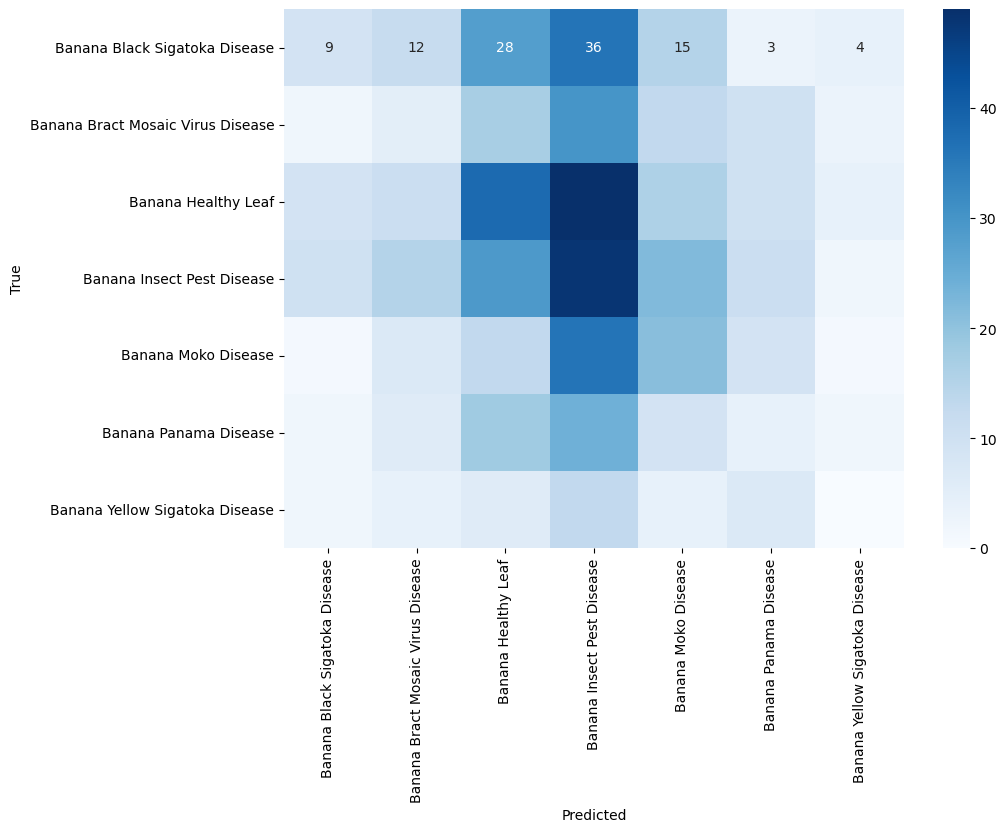

In [61]:
y_pred = np.argmax(loaded_model.predict(val_generator), axis=1)

y_true = val_generator.classes

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices, yticklabels=val_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
Predicted Class: Banana Black Sigatoka Disease
Prediction Confidence: 97.37%


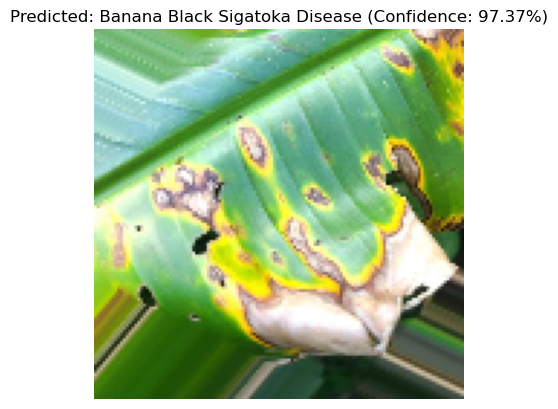

In [62]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

model = load_model("best_advanced_model.keras")

image_path = "Banana Leaf Disease Detection dataset/Banana Black Sigatoka Disease/Augmented Banana Black Sigatoka Disease (24).jpg"

img = image.load_img(image_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0  

img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)

predicted_class = np.argmax(predictions, axis=1)[0]  
confidence = np.max(predictions) * 100  

class_dict = train_generator.class_indices

predicted_class_name = [key for key, value in class_dict.items() if value == predicted_class][0]

print(f"Predicted Class: {predicted_class_name}")
print(f"Prediction Confidence: {confidence:.2f}%")

plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f}%)")
plt.axis('off')  # Hide axes
plt.show()

82/82 ━━━━━━━━━━━━━━━━━━━━ 62s 748ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 674ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 58s 703ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 680ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 61s 746ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 711ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 53s 647ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 712ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 54s 655ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 706ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 60s 732ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 707ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 60s 734ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 706ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 60s 735ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 715ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 60s 730ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 684ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 67s 821ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 751ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 61s 736ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 402ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 53s 645ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 722m

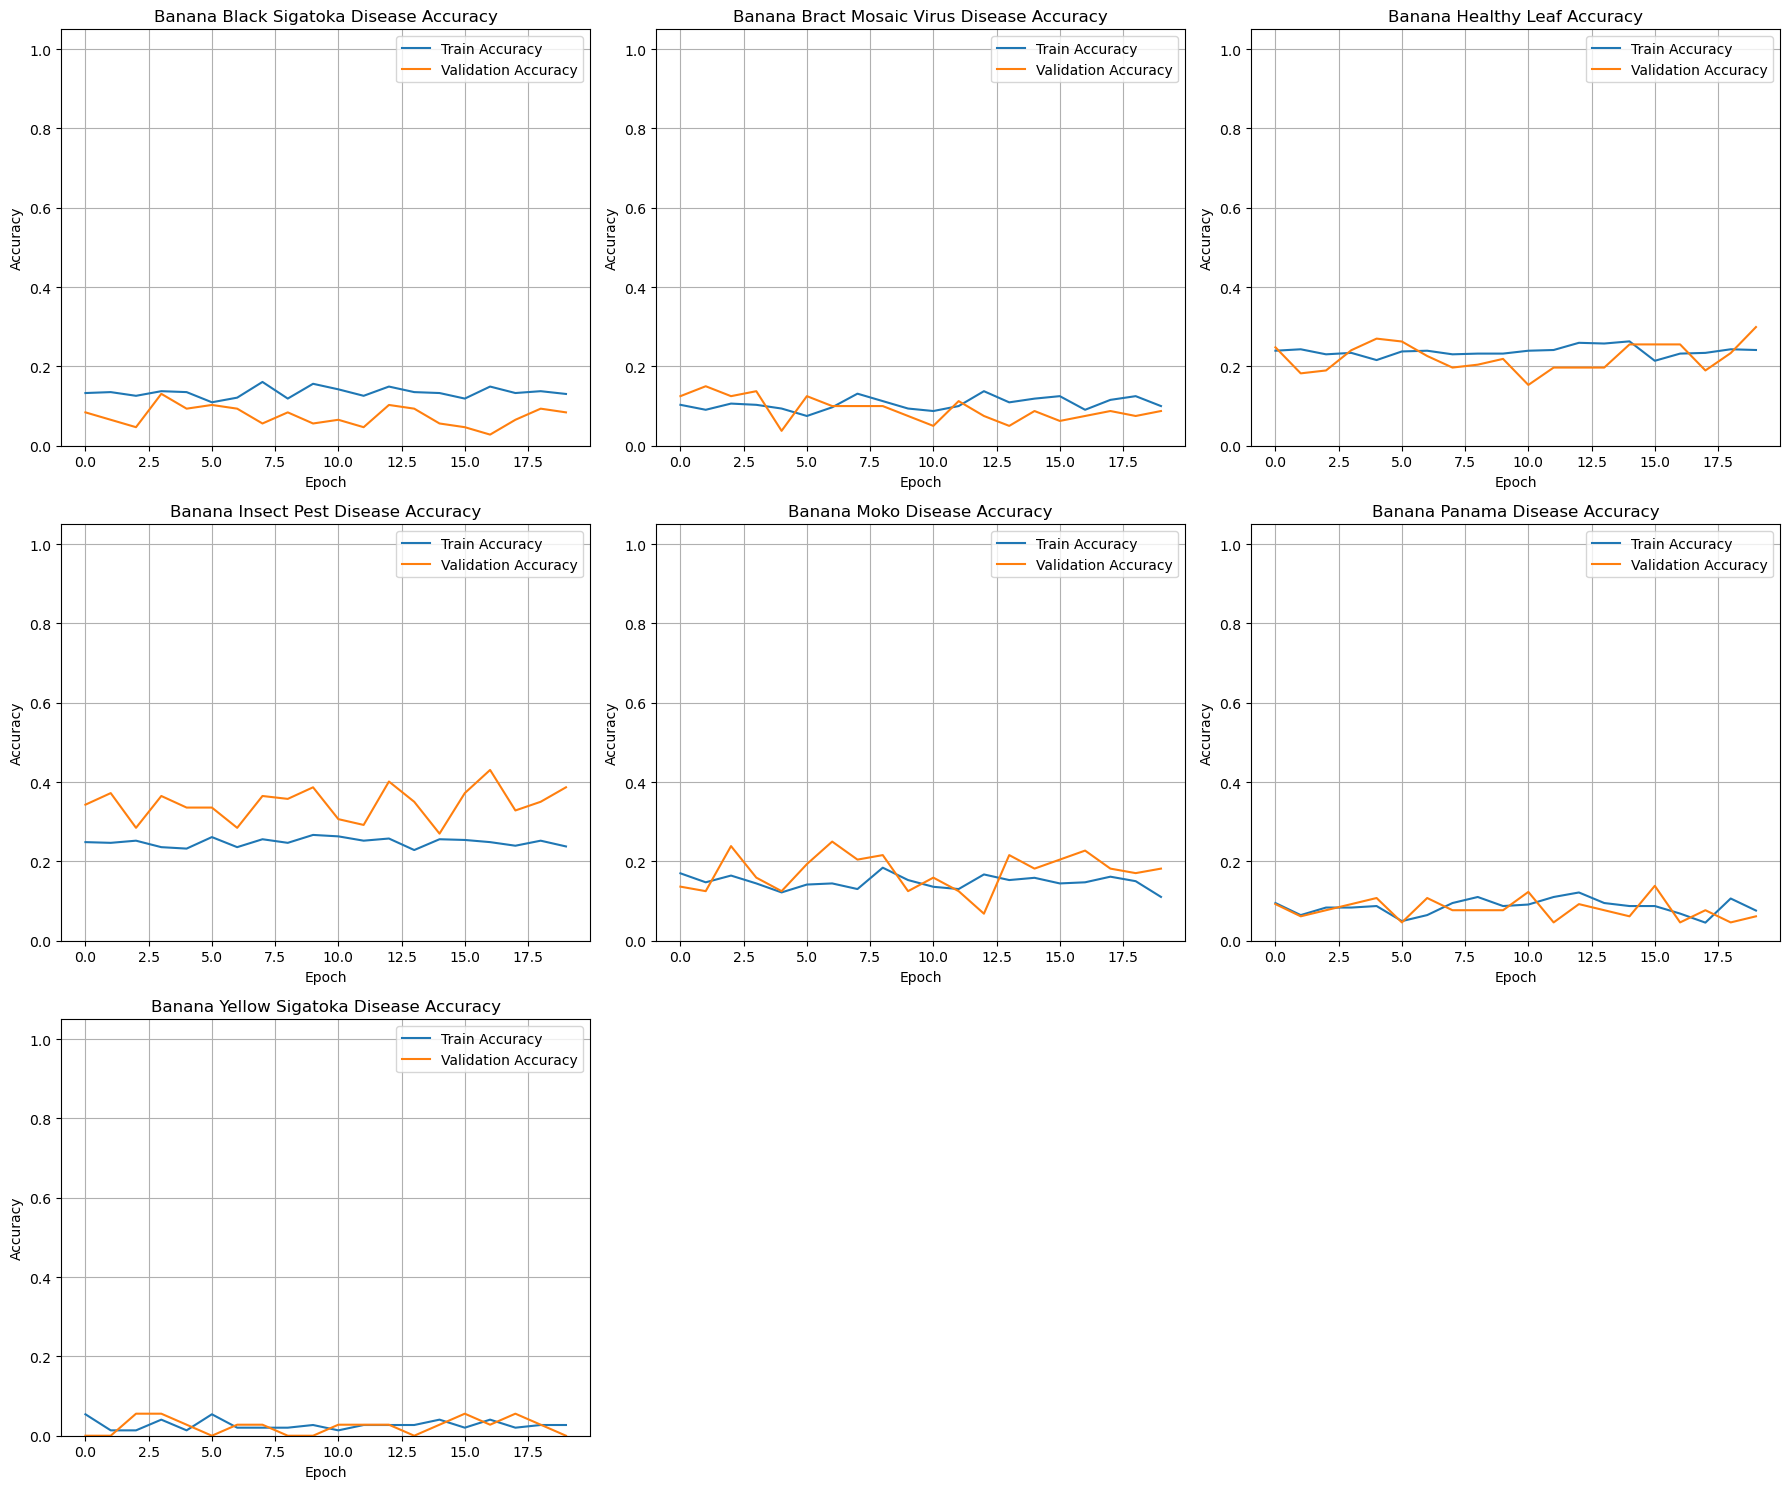

In [63]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class DiseaseAccuracyTracker:
    def __init__(self, model, train_gen, val_gen):
        self.model = model
        self.train_gen = train_gen
        self.val_gen = val_gen
        self.class_names = list(train_gen.class_indices.keys())
        self.train_acc_history = {name: [] for name in self.class_names}
        self.val_acc_history = {name: [] for name in self.class_names}
    
    def calculate_per_class_accuracy(self, generator, mode='train'):
        y_pred = np.argmax(self.model.predict(generator), axis=1)
        y_true = generator.classes
        cm = confusion_matrix(y_true, y_pred)
        class_acc = cm.diagonal() / cm.sum(axis=1)
        
        for i, name in enumerate(self.class_names):
            if mode == 'train':
                self.train_acc_history[name].append(class_acc[i])
            else:
                self.val_acc_history[name].append(class_acc[i])
    
    def plot_individual_accuracy(self):
        plt.figure(figsize=(18, 15))
        for i, name in enumerate(self.class_names):
            plt.subplot(3, 3, i+1)  # 3x3 grid for 7 diseases (one empty spot)
            plt.plot(self.train_acc_history[name], label='Train Accuracy')
            plt.plot(self.val_acc_history[name], label='Validation Accuracy')
            plt.title(f'{name} Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.ylim(0, 1.05)
            plt.legend()
            plt.grid(True)
        plt.tight_layout()
        plt.show()

# Initialize tracker
tracker = DiseaseAccuracyTracker(model, train_generator, val_generator)

# Simulate epoch-by-epoch training (since we can't modify your existing fit() call)
for epoch in range(len(history.history['accuracy'])):
    # Calculate training accuracy
    tracker.calculate_per_class_accuracy(train_generator, mode='train')
    
    # Calculate validation accuracy
    tracker.calculate_per_class_accuracy(val_generator, mode='val')

# Plot all disease accuracy curves
tracker.plot_individual_accuracy()

# Optionally save individual plots
for disease in tracker.class_names:
    plt.figure(figsize=(8, 5))
    plt.plot(tracker.train_acc_history[disease], label='Train')
    plt.plot(tracker.val_acc_history[disease], label='Validation')
    plt.title(f'{disease} Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'{disease.replace(" ", "_")}_accuracy.png', bbox_inches='tight')
    plt.close()
    